In [1]:
from neuron import h
import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

h.load_file('stdrun.hoc')
T =3055  # ms
simdur = 19.5* T  #Use large multiples of T  to get a good estimate of the limit cycle

In [2]:
def performance(gfb, gsyn, plot=False):
    #Calculate mean rate of progress over the limit cycle, or fallback using ΔQ/Δt
    sec = h.Section(name='mod')
    sec.insert('braina')
    sec.insert('bodya')
    seg = sec(0.5)

    seg.braina.gfb = gfb
    seg.braina.gsyn = gsyn
    seg.braina._ref_L1Pointer = seg.bodya._ref_L1
    seg.braina._ref_L2Pointer = seg.bodya._ref_L2
    seg.bodya._ref_V1Pointer  = seg.braina._ref_V1
    seg.bodya._ref_V2Pointer  = seg.braina._ref_V2

    # Record variables
    Qv = h.Vector().record(seg.bodya._ref_Q)
    V1v = h.Vector().record(seg.braina._ref_V1)
    tv = h.Vector().record(h._ref_t)

    # Run simulation
    h.finitialize()
    h.cvode.active(1)
    h.continuerun(simdur)

    # Convert to NumPy arrays
    Q = np.array(Qv)
    V1 = np.array(V1v)
    t = np.array(tv)

    try:
        peaks, _ = find_peaks(V1, height=np.max(V1)*0.5, distance=0.5*T)

        if len(peaks) >= 2:
            # Use last full cycle
            start_idx, end_idx = peaks[-2], peaks[-1]
            t_start, t_end = t[start_idx], t[end_idx]
            Q_start, Q_end = Q[start_idx], Q[end_idx]

            perf = (Q_end - Q_start) / (t_end - t_start)

            if plot:
                plt.figure(figsize=(10, 4))
                plt.plot(t, V1, label='V1')
                plt.axvline(t_start, color='green', linestyle='--', label='Cycle Start')
                plt.axvline(t_end, color='red', linestyle='--', label='Cycle End')
                plt.title(f'Limit Cycle Detection in V1 (gfb={gfb}, gsyn={gsyn})')
                plt.xlabel('Time (ms)')
                plt.ylabel('V1')
                plt.legend()
                plt.grid(True)
                plt.show()
                print(f"Performance = {perf:.6f} ")
            return perf

        else:
            # Fallback: Not enough peaks, use entire interval
            t_start, t_end = t[0], t[-1]
            Q_start, Q_end = Q[0], Q[-1]
            avg_perf = (Q_end - Q_start) / (t_end - t_start)
            if plot:
                print(" Not enough peaks to define a full cycle.")
                print(f"Fallback to average using ΔQ/Δt = ({Q_end:.4f} - {Q_start:.4f}) / ({t_end:.2f} - {t_start:.2f})")
                print(f"Performance = {avg_perf:.6f} ")
            return avg_perf

    except Exception as e:
        # Last resort fallback
        t_start, t_end = t[0], t[-1]
        Q_start, Q_end = Q[0], Q[-1]
        avg_perf = (Q_end - Q_start) / (t_end - t_start)
        if plot:
            print(f" Peak detection failed: {e}")
            print(f"Performance = {avg_perf:.6f} ")
        return avg_perf


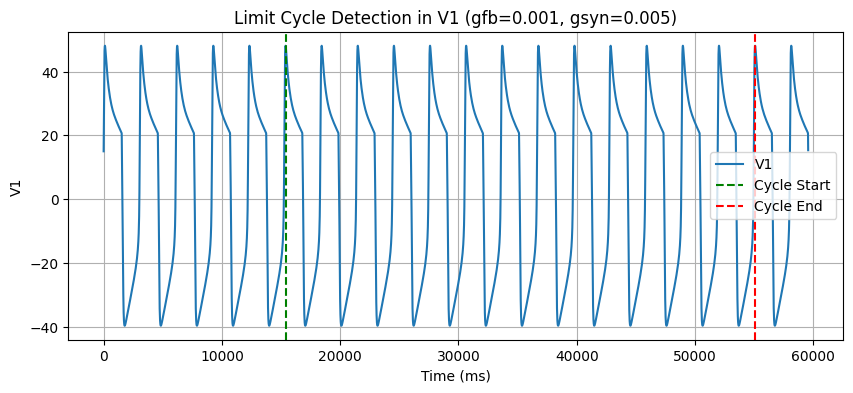

Performance = 0.001231 

Original performance: 0.001231



In [3]:
original_gfb = 0.001
original_gsyn = 0.005
original_Q = performance(original_gfb, original_gsyn, plot=True)
print(f"\nOriginal performance: {original_Q:.6f}\n")

At the beginning of the simulation, the dynamics are affected by transients and initial conditions, so the neuron does not yet follow a regular limit cycle. If I measure performance too early, the result will reflect this unstable phase and give incorrect values. By running the simulation longer, the system has enough time to reach the limit cycle where the voltage oscillations become consistent in shape and timing.In the performance function, I tried to detect the last full cycle using peak detection after a long simulation and tried to ensure that transients are excluded. This makes the computed performance a reliable average over the true steady-state limit cycle.






I detected the limit cycle by identifying where the voltage trace V1(t) became periodic which is  showing consistent spike shape and timing. The green and red dashed lines mark one full, stable oscillation cycle.

gsyn=0.001000, Performance=0.000997
gsyn=0.001592, Performance=0.001120
gsyn=0.002184, Performance=0.001209
gsyn=0.002776, Performance=0.001245
gsyn=0.003367, Performance=0.001266
gsyn=0.003959, Performance=0.001268
gsyn=0.004551, Performance=0.001252
gsyn=0.005143, Performance=0.001223
gsyn=0.005735, Performance=0.001181
gsyn=0.006327, Performance=0.001130
gsyn=0.006918, Performance=0.001075
gsyn=0.007510, Performance=0.001021
gsyn=0.008102, Performance=0.000976
gsyn=0.008694, Performance=0.000940
gsyn=0.009286, Performance=0.000912
gsyn=0.009878, Performance=0.000889
gsyn=0.010469, Performance=0.000869
gsyn=0.011061, Performance=0.000852
gsyn=0.011653, Performance=0.000838
gsyn=0.012245, Performance=0.000825
gsyn=0.012837, Performance=0.000813
gsyn=0.013429, Performance=0.000803
gsyn=0.014020, Performance=0.000794
gsyn=0.014612, Performance=0.000785
gsyn=0.015204, Performance=0.000777
gsyn=0.015796, Performance=0.000771
gsyn=0.016388, Performance=0.000766
gsyn=0.016980, Performance=0

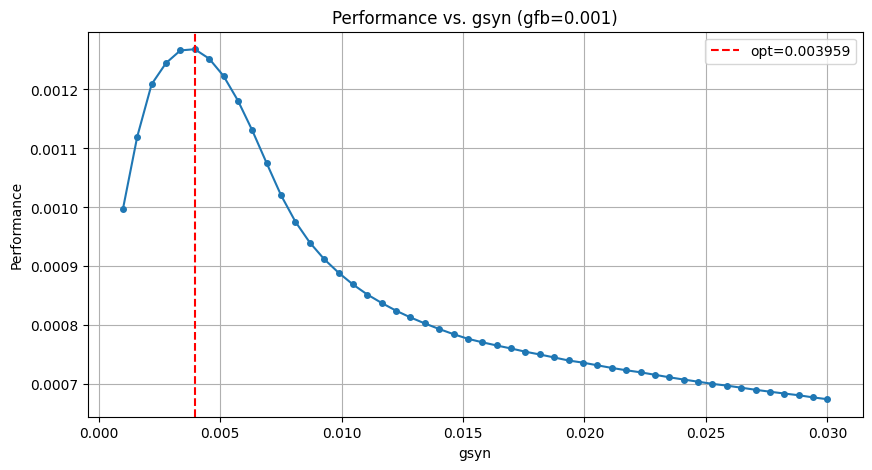

In [4]:
gsyn_vals = np.linspace(0.001, 0.03, 50)  
Q_gsyn = []
for g in gsyn_vals:
    Q = performance(0.001, g)
    Q_gsyn.append(Q)
    print(f"gsyn={g:.6f}, Performance={Q:.6f}")

opt_j = np.argmax(Q_gsyn)
print(f"\n Optimum gsyn = {gsyn_vals[opt_j]:.6f}, Performance = {Q_gsyn[opt_j]:.3e}")

plt.figure(figsize=(10, 5))
plt.plot(gsyn_vals, Q_gsyn, '-o', markersize=4)
plt.axvline(gsyn_vals[opt_j], color='red', linestyle='--',
            label=f"opt={gsyn_vals[opt_j]:.6f}")
plt.xlabel('gsyn')
plt.ylabel('Performance')
plt.title('Performance vs. gsyn (gfb=0.001)')
plt.grid(True)
plt.legend()
plt.show()

gfb=0.000050, Performance=0.001304
gfb=0.000253, Performance=0.001290
gfb=0.000456, Performance=0.001275
gfb=0.000659, Performance=0.001260
gfb=0.000862, Performance=0.001243
gfb=0.001065, Performance=0.001225
gfb=0.001268, Performance=0.001206
gfb=0.001471, Performance=0.001186
gfb=0.001674, Performance=0.001165
gfb=0.001878, Performance=0.001142
gfb=0.002081, Performance=0.001116
gfb=0.002284, Performance=0.001087
gfb=0.002487, Performance=0.001050
gfb=0.002690, Performance=0.001001
gfb=0.002893, Performance=0.000824
gfb=0.003096, Performance=0.000745
gfb=0.003299, Performance=0.000667
gfb=0.003502, Performance=0.000593
gfb=0.003705, Performance=0.000594
gfb=0.003908, Performance=0.000440
gfb=0.004111, Performance=0.000361
gfb=0.004314, Performance=0.000134
gfb=0.004517, Performance=0.000338
gfb=0.004720, Performance=-0.000113
gfb=0.004923, Performance=-0.000124
gfb=0.005127, Performance=0.000119
gfb=0.005330, Performance=-0.000130
gfb=0.005533, Performance=-0.000142
gfb=0.005736, Pe

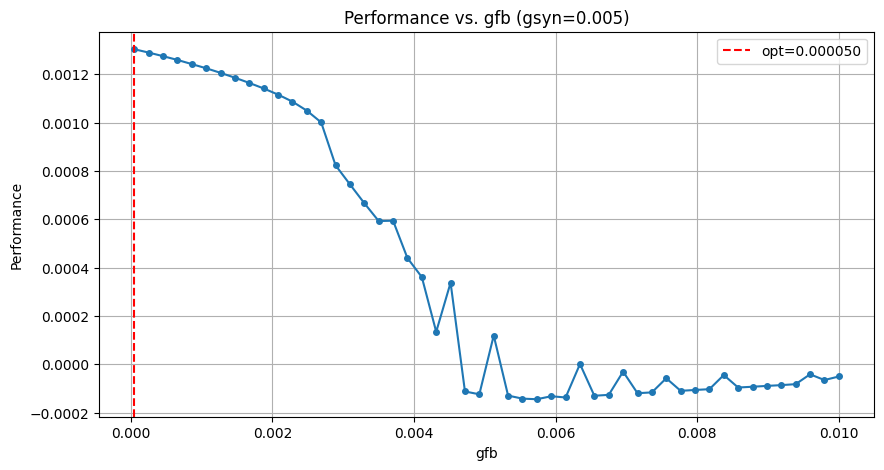

In [5]:
# gfb with extended range
gfb_vals = np.linspace(0.00005, 0.01, 50)  
Q_gfb = []
for g in gfb_vals:
    Q = performance(g, 0.005)
    Q_gfb.append(Q)
    print(f"gfb={g:.6f}, Performance={Q:.6f}")

opt_i = np.argmax(Q_gfb)
print(f"\n Optimum gfb = {gfb_vals[opt_i]:.6f}, Performance = {Q_gfb[opt_i]:.3e}")

plt.figure(figsize=(10, 5))
plt.plot(gfb_vals, Q_gfb, '-o', markersize=4)
plt.axvline(gfb_vals[opt_i], color='red', linestyle='--', 
            label=f"opt={gfb_vals[opt_i]:.6f}")
plt.xlabel('gfb')
plt.ylabel('Performance')
plt.title('Performance vs. gfb (gsyn=0.005)')
plt.grid(True)
plt.legend()
plt.show()

gfb=0.000050, gsyn=0.001000, Performance=0.000066
gfb=0.000050, gsyn=0.001569, Performance=0.000600
gfb=0.000050, gsyn=0.002137, Performance=0.000828
gfb=0.000050, gsyn=0.002706, Performance=0.001274
gfb=0.000050, gsyn=0.003274, Performance=0.001310
gfb=0.000050, gsyn=0.003843, Performance=0.001324
gfb=0.000050, gsyn=0.004411, Performance=0.001322
gfb=0.000050, gsyn=0.004980, Performance=0.001305
gfb=0.000050, gsyn=0.005548, Performance=0.001278
gfb=0.000050, gsyn=0.006117, Performance=0.001241
gfb=0.000050, gsyn=0.006685, Performance=0.001197
gfb=0.000050, gsyn=0.007254, Performance=0.001144
gfb=0.000050, gsyn=0.007822, Performance=0.001090
gfb=0.000050, gsyn=0.008391, Performance=0.001039
gfb=0.000050, gsyn=0.008959, Performance=0.000997
gfb=0.000193, gsyn=0.001000, Performance=0.000066
gfb=0.000193, gsyn=0.001569, Performance=0.000593
gfb=0.000193, gsyn=0.002137, Performance=0.001201
gfb=0.000193, gsyn=0.002706, Performance=0.001271
gfb=0.000193, gsyn=0.003274, Performance=0.001304


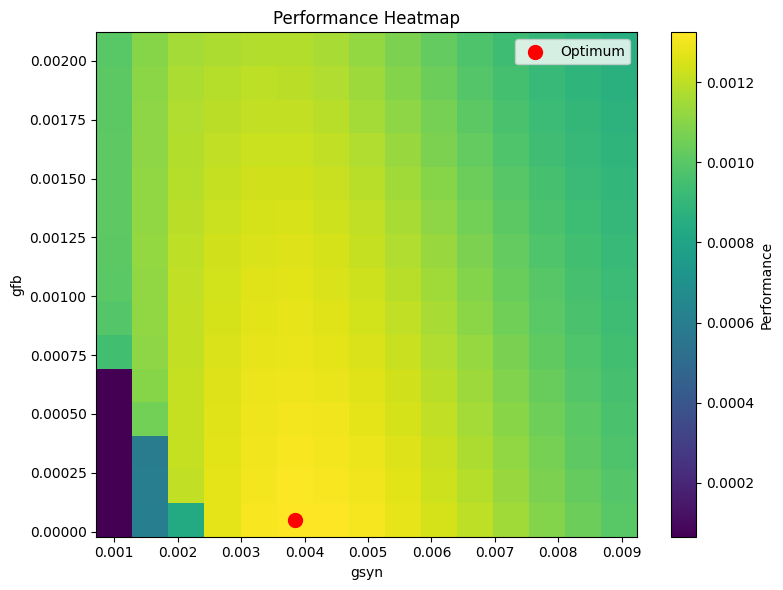

In [6]:
# Define parameter sweep ranges centered around current optima
gfb_center = gfb_vals[opt_i]
gsyn_center = gsyn_vals[opt_j]

gfb_range = np.linspace(max(0.00005, gfb_center - 0.002), 
                        min(0.01, gfb_center + 0.002), 15)
gsyn_range = np.linspace(max(0.001, gsyn_center - 0.005),
                         min(0.03, gsyn_center + 0.005), 15)

# Initialize 
P = np.zeros((len(gfb_range), len(gsyn_range)))

# Evaluate performance over the grid
for i, gfb in enumerate(gfb_range):
    for j, gsyn in enumerate(gsyn_range):
        try:
            P[i, j] = performance(gfb, gsyn)
            print(f"gfb={gfb:.6f}, gsyn={gsyn:.6f}, Performance={P[i, j]:.6f}")
        except Exception as e:
            P[i, j] = np.nan
            print(f"gfb={gfb:.6f}, gsyn={gsyn:.6f}, Error: {e}")


i_opt, j_opt = np.unravel_index(np.nanargmax(P), P.shape)
gfb_opt = gfb_range[i_opt]
gsyn_opt = gsyn_range[j_opt]
optimal_perf = P[i_opt, j_opt]

print(f"\nJoint optimum (gfb, gsyn) = ({gfb_opt:.6f}, {gsyn_opt:.6f}), Performance = {optimal_perf:.3e}")
change = (optimal_perf - original_Q) * 100 / original_Q
print(f"Change in performance from original: {change:.1f} %")

fig, ax = plt.subplots(figsize=(8, 6))

pcm = ax.pcolormesh(gsyn_range, gfb_range, P, shading='auto', cmap='viridis')
plt.colorbar(pcm, ax=ax, label='Performance')


ax.scatter(gsyn_opt, gfb_opt, c='red', s=100, label='Optimum')
ax.set_xlabel('gsyn')
ax.set_ylabel('gfb')
ax.set_title('Performance Heatmap')
ax.legend()

plt.tight_layout()
plt.show()



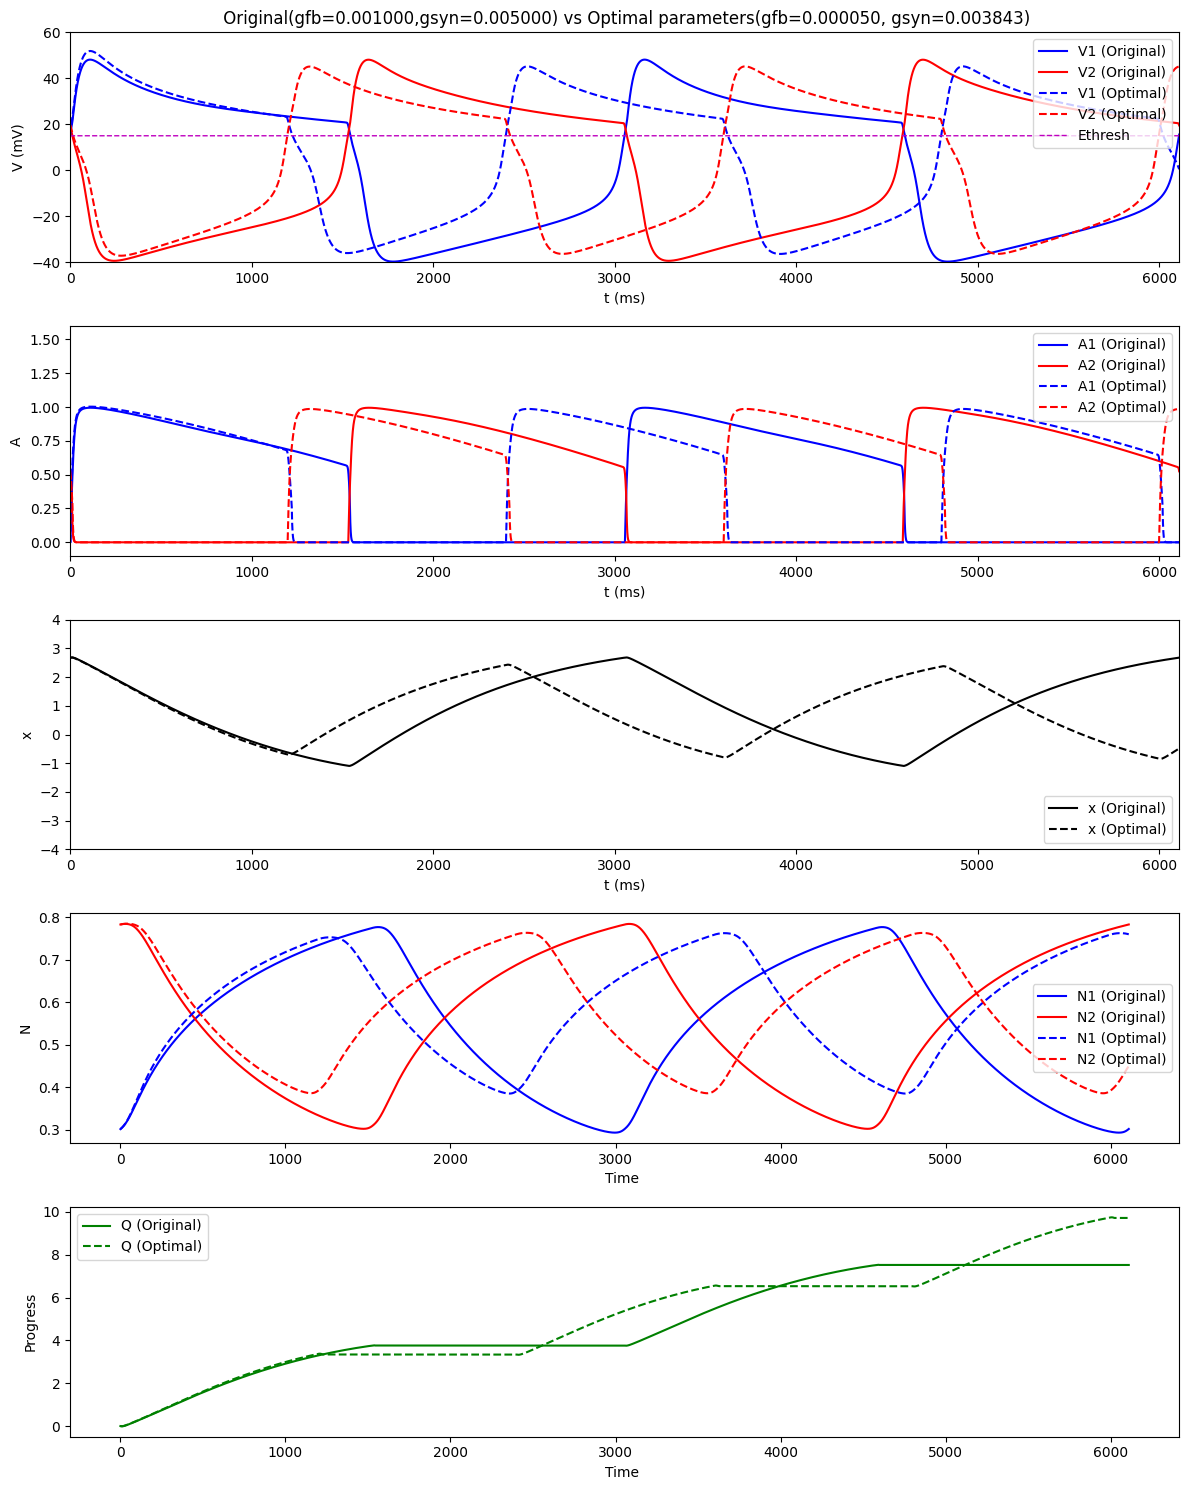

In [7]:
def solution(gfb, gsyn, label):

    model = h.Section(name='model')
    model.insert('braina')
    model.insert('bodya')
    seg = model(0.5)

    seg.braina.gfb = gfb
    seg.braina.gsyn = gsyn
    seg.braina._ref_L1Pointer = seg.bodya._ref_L1
    seg.braina._ref_L2Pointer = seg.bodya._ref_L2
    seg.bodya._ref_V1Pointer = seg.braina._ref_V1
    seg.bodya._ref_V2Pointer = seg.braina._ref_V2

    results = {
        'N1': h.Vector(),
        'N2': h.Vector(),
        'V1': h.Vector(),
        'V2': h.Vector(),
        'A1': h.Vector(),
        'A2': h.Vector(),
        'x': h.Vector(),
        'Q': h.Vector(),
        't': h.Vector(),
        'label': label
    }
    
   
    results['N1'].record(seg.braina._ref_N1)
    results['N2'].record(seg.braina._ref_N2)
    results['V1'].record(seg.braina._ref_V1)
    results['V2'].record(seg.braina._ref_V2)
    results['A1'].record(seg.bodya._ref_A1)
    results['A2'].record(seg.bodya._ref_A2)
    results['x'].record(seg.bodya._ref_x)
    results['Q'].record(seg.bodya._ref_Q)
    results['t'].record(h._ref_t)

   
    h.load_file('stdrun.hoc')
    h.init()
    h.cvode.active(0)  
    h.dt = 0.1        
    h.steps_per_ms = 10
    h.tstop = 2*T
    h.run()
    
    # Convert recorded vectors to numpy arrays
    for key in results:
        if key != 'label':
            results[key] = np.array(results[key])
    
    return results


original_results = solution(original_gfb, original_gsyn, "Original")
optimal_results = solution(gfb_opt, gsyn_opt, "Optimal")


plt.figure(figsize=(12, 15))


ax1 = plt.subplot(511)
ax1.plot(original_results['t'], original_results['V1'], 'b-',  label=f'V1 ({original_results["label"]})')
ax1.plot(original_results['t'], original_results['V2'], 'r-', label=f'V2 ({original_results["label"]})')
ax1.plot(optimal_results['t'], optimal_results['V1'], 'b--', linewidth=1.5, label=f'V1 ({optimal_results["label"]})')
ax1.plot(optimal_results['t'], optimal_results['V2'], 'r--', linewidth=1.5, label=f'V2 ({optimal_results["label"]})')
ax1.plot(optimal_results['t'], 15 * np.ones(len(optimal_results['t'])), '--m', linewidth=1, label='Ethresh')
ax1.axis([0, h.tstop, -40, 60])
ax1.set_xlabel('t (ms)')
ax1.set_ylabel('V (mV)')
ax1.legend(loc='upper right', frameon=True)
ax1.set_title(f' Original(gfb={original_gfb:.6f},gsyn={original_gsyn:.6f}) vs Optimal parameters(gfb={gfb_opt:.6f}, gsyn={gsyn_opt:.6f})')


ax2 = plt.subplot(512)
ax2.plot(original_results['t'], original_results['A1'], 'b-',  label=f'A1 ({original_results["label"]})')
ax2.plot(original_results['t'], original_results['A2'], 'r-',  label=f'A2 ({original_results["label"]})')
ax2.plot(optimal_results['t'], optimal_results['A1'], 'b--', linewidth=1.5, label=f'A1 ({optimal_results["label"]})')
ax2.plot(optimal_results['t'], optimal_results['A2'], 'r--', linewidth=1.5, label=f'A2 ({optimal_results["label"]})')
ax2.axis([0, h.tstop, -0.1, 1.6])
ax2.set_xlabel('t (ms)')
ax2.set_ylabel('A')
ax2.legend(loc='upper right', frameon=True)


ax3 = plt.subplot(513)
ax3.plot(original_results['t'], original_results['x'], 'k-',  label=f'x ({original_results["label"]})')
ax3.plot(optimal_results['t'], optimal_results['x'], 'k--', linewidth=1.5, label=f'x ({optimal_results["label"]})')
ax3.axis([0, h.tstop, -4, 4])
ax3.set_xlabel('t (ms)')
ax3.set_ylabel('x')
ax3.legend(loc='lower right', frameon=True)


ax4 = plt.subplot(514)
ax4.plot(original_results['t'], original_results['N1'], 'b-',  label=f'N1 ({original_results["label"]})')
ax4.plot(original_results['t'], original_results['N2'], 'r-',  label=f'N2 ({original_results["label"]})')
ax4.plot(optimal_results['t'], optimal_results['N1'], 'b--', linewidth=1.5, label=f'N1 ({optimal_results["label"]})')
ax4.plot(optimal_results['t'], optimal_results['N2'], 'r--', linewidth=1.5, label=f'N2 ({optimal_results["label"]})')
ax4.set_xlabel('Time ')
ax4.set_ylabel('N')
ax4.legend()


ax5 = plt.subplot(515)
ax5.plot(original_results['t'], original_results['Q'], 'g-',  label=f'Q ({original_results["label"]})')
ax5.plot(optimal_results['t'], optimal_results['Q'], 'g--', linewidth=1.5, label=f'Q ({optimal_results["label"]})')
ax5.set_xlabel('Time ')
ax5.set_ylabel('Progress')
ax5.legend()

plt.tight_layout()  
plt.show()